In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib
import pickle
import text_classifier as text_clf
import sys
sys.path.append("..")
import common

In [2]:
news_train, news_test = common.load_data('news')
spam_train, spam_test = common.load_data('spam')

In [3]:
def cross_validate(X, y, k, dims, num_epochs=5, ngrams=3):
    kf = KFold(k)
    results = {D: [] for D in dims}

    for D in dims:
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            clf = text_clf.TextClassifier(X_train, y_train, embed_dim=D, ngrams=ngrams, num_epochs=num_epochs)

            predictions = [clf.predict(text) for text in X_val]
            acc = (predictions == y_val).sum() / y_val.shape[0]
            results[D].append(acc)
    results = {D: np.mean(accs) for D, accs in results.items()}
    return results

In [4]:
# WARNING: TAKES LITERALlY FOREVER TO RUN FOR NEWS 

#ngrams = [1,2,3] 
#for n in ngrams:
#    accuracies = cross_validate(spam_train['texts'], spam_train['labels'], k=5, dims=range(1,50,4), ngrams=n)
#    pickle.dump(accuracies, open(f'spam_accs_{n}grams.p', 'wb'))

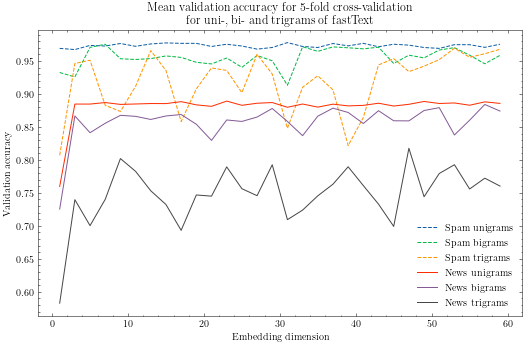

In [7]:
plt.style.use(['science'])

plt.figure(figsize=(7.5,5))
spam_acc_files = [f"CV/spam_acc_all_{n}grams.p" for n in [1,2,3]]
spam_acc_data = [pickle.load(open(file, 'rb')) for file in spam_acc_files]
for data, label in zip(spam_acc_data, ["unigrams", "bigrams", "trigrams"]):
    plt.plot(list(data.keys()), list(data.values()), '--', label=f"Spam {label}")

news_acc_files = [f"CV/news_acc_all_{n}grams.p" for n in [1,2,3]]
news_acc_data = [pickle.load(open(file, 'rb')) for file in news_acc_files]
for data, label in zip(news_acc_data, ["unigrams", "bigrams", "trigrams"]):
    plt.plot(list(data.keys()), list(data.values()), '-', label=f"News {label}")

plt.legend()
plt.xlabel('Embedding dimension')
plt.ylabel('Validation accuracy')
plt.title('Mean validation accuracy for 5-fold cross-validation\n for uni-, bi- and trigrams of fastText')
plt.tight_layout()
plt.savefig("val_accs.pdf", bbox_inches='tight')

In [14]:
max(spam_acc_data[1].items(), key=lambda x: x[1])

(7, 0.9753204692666575)

Train and save classifier to avoid re-training

switch `train_classifiers` to `True` if the `*_fasttext_classifiers.p`'s havn't been trained and `pickle.dump`'ed

news_fasttext_classifier.p should be around 580mb

In [15]:
train_classifiers = True

In [16]:
if train_classifiers:
    spam_clf = text_clf.TextClassifier(spam_train['texts'], spam_train['labels'], embed_dim=31, ngrams=1)
    pickle.dump(spam_clf, open('spam_fasttext_classifier.p', 'wb'))
else:
    spam_clf = pickle.load(open('spam_fasttext_classifier.p', 'rb'))

4457lines [00:00, 22976.99lines/s]Constructing vocabulary...

100%|██████████| 4457/4457 [00:00<00:00, 8907.73it/s]
Training model...
Epoch: 1  | time in 0 minutes, 1 seconds
	Loss: 0.0118(train)	|	Acc: 92.4%(train)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.0043(train)	|	Acc: 97.8%(train)
Epoch: 3  | time in 0 minutes, 1 seconds
	Loss: 0.0026(train)	|	Acc: 99.0%(train)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.0017(train)	|	Acc: 99.4%(train)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.0011(train)	|	Acc: 99.6%(train)



In [17]:
spam_acc = accuracy_score(spam_test['labels'], [spam_clf.predict(text) for text in spam_test['texts']])
print(f'Test accuracy for spam: {round(spam_acc,3)}')

Test accuracy for spam: 0.972


In [18]:
spam_train_emb = [spam_clf.get_text_embedding(text) for text in spam_train['texts']]

In [19]:
if train_classifiers:
    news_clf = text_clf.TextClassifier(news_train['texts'], news_train['labels'], embed_dim=23, ngrams=1)
    pickle.dump(news_clf, open('news_fasttext_classifier.p', 'wb'))
else:
    news_clf = pickle.load(open('news_fasttext_classifier.p', 'rb'))

1064lines [00:00, 10636.31lines/s]Constructing vocabulary...
120000lines [00:11, 10175.42lines/s]
100%|██████████| 120000/120000 [00:17<00:00, 7009.98it/s]
Training model...
Epoch: 1  | time in 0 minutes, 30 seconds
	Loss: 0.0254(train)	|	Acc: 85.6%(train)
Epoch: 2  | time in 0 minutes, 25 seconds
	Loss: 0.0165(train)	|	Acc: 91.1%(train)
Epoch: 3  | time in 0 minutes, 32 seconds
	Loss: 0.0141(train)	|	Acc: 92.4%(train)
Epoch: 4  | time in 0 minutes, 37 seconds
	Loss: 0.0124(train)	|	Acc: 93.2%(train)
Epoch: 5  | time in 0 minutes, 29 seconds
	Loss: 0.0112(train)	|	Acc: 93.8%(train)



In [20]:
news_acc = accuracy_score(news_test['labels'], [news_clf.predict(text) for text in news_test['texts']])
print(f'Test accuracy for news: {round(news_acc,3)}')

Test accuracy for news: 0.906


In [53]:
news_train_emb = [news_clf.get_text_embedding(text) for text in news_train['texts']]